## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
# Import Packages
import glob  # OS dependencies to get file system details
import cv2
#importing some useful packages
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from ipywidgets import interact, interactive, fixed

%matplotlib inline

In [2]:
def show_images(images, gray=None, divider = 2):
    """
    This is an utility function to show multiple images with different colour maps

    :param images - An images list
    :param gray - A flag to set default value for matplotlib imshow colour map. If the image
                  shape is 2( i.e binary image) then cmap value will be "gray"
    :return: Nothing
    """
    rows = (len(images)+1)//divider
    plt.figure(figsize=(16, 16))
    for idx, img in enumerate(images):
        plt.subplot(rows, divider, idx+1)
        # if the image is binary then it'll be printed as grayscale, otherwise colour map
        # will be ignored
        plt.imshow(img, cmap="gray" if len(img.shape) == 2 else gray)
        plt.xticks([])
        plt.yticks([])

    plt.show()

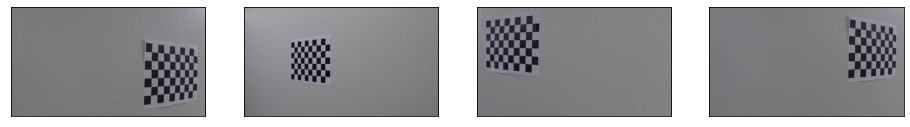

In [3]:
# Loading test images from test_image directory
camera_cal_imgs = [mpimg.imread(path) for path in glob.glob("camera_cal/*")]

# Visualize calibration images
show_images(camera_cal_imgs[:4], divider=4)

In [4]:
def grayscale(img, opencv_read=False):
    """

    :param img:
    :param opencv_read:
    :return:
    """
    if opencv_read:
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


In [5]:
# prepare objects points
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and iamg points from all the images
objpoints = []
imgpoints = []

def find_and_draw_chessboard(img, pattern_size= (9,6)):
    gray = grayscale(img)

    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)

    # if found, add object points, image points
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

        # draw and display the corners
        cv2.drawChessboardCorners(img, pattern_size, corners, ret)
    
    # if not found, return same input image
    return img

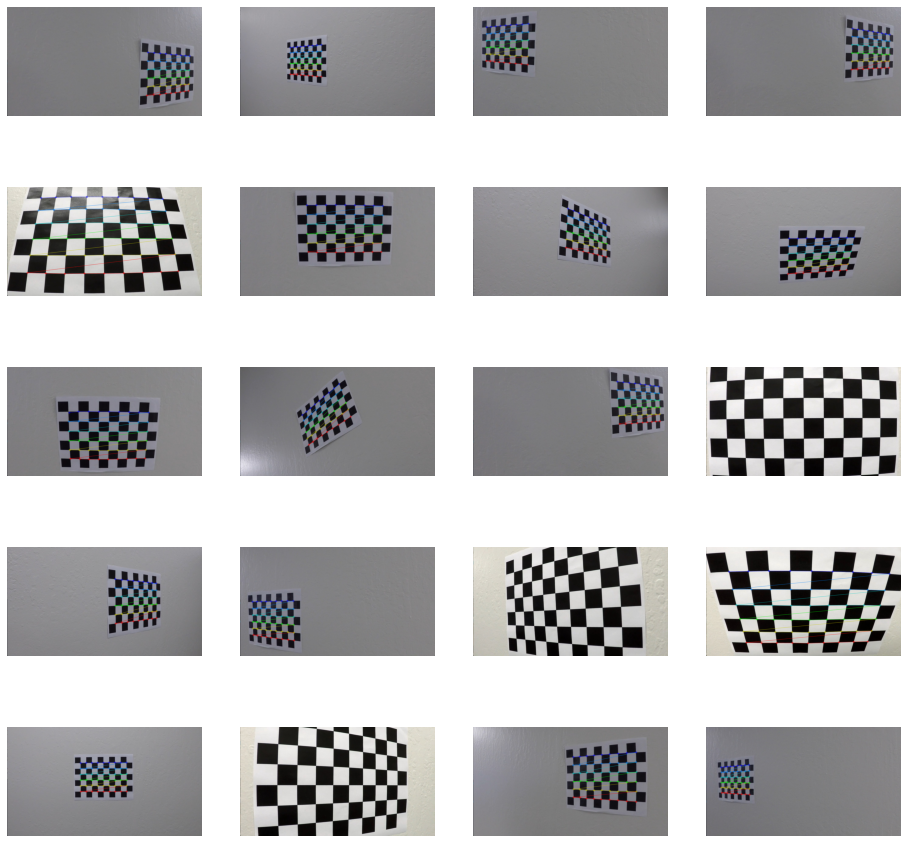

In [6]:
# Draw subplots dynamically
fig, axs = plt.subplots(5,4, figsize=(16, 16))
axs = axs.ravel()

for idx, img in enumerate(camera_cal_imgs):
    res_img = find_and_draw_chessboard(img)        
    axs[idx].axis('off')
    axs[idx].imshow(res_img)

### Camera calibration
Camera resectioning determines which incoming light is associated with each pixel on the resulting image.

In [7]:
#cache an image to further reuse
sample_img = mpimg.imread("camera_cal/calibration1.jpg")
#cache image size to further reuse
img_size = sample_img.shape[:2]

# Do Camera calibration given objects' points and images' points
# mtx - camera calibrated matrix
# dist - distortion cofficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,img_size, None, None)

# Save the Camera calibration results for later use
dist_pickle = {"mtx": mtx, "dist": dist}
pickle.dump( dist_pickle, open( "resources/calibration.p", "wb" ) )

#### Distortion correction

Image distortion occurs when a camera looks at 3D objects in the real world and transforms them into a 2D image; this transformation isn’t perfect. Distortion actually changes what the shape and size of these 3D objects appear to be. So, the first step in analyzing camera images, is to undo this distortion so that you can get correct and useful information out of them.

In [8]:
def undistort(img):
    """
    This is used to undistort distortion images by using camera calibration matrix and distortion cofficients
    
    :param img - Input image
    :return - undistort image
    """
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist

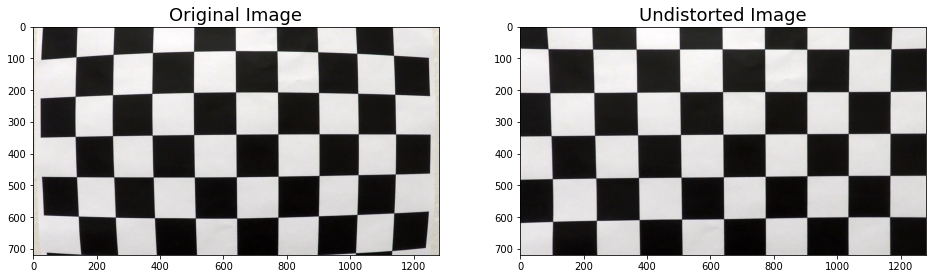

In [9]:
def undistort_image(img):
    """
    This is used to visualize distortion corrected images with the original image.
    :param sample_img:
    :param cmatrix:
    :param distc:
    :return:
    """
    udistord_img = undistort(img)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,16))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=18)
    ax2.imshow(udistord_img)
    ax2.set_title('Undistorted Image', fontsize=18)
    # this can be used
    return udistord_img

res = undistort_image(sample_img)

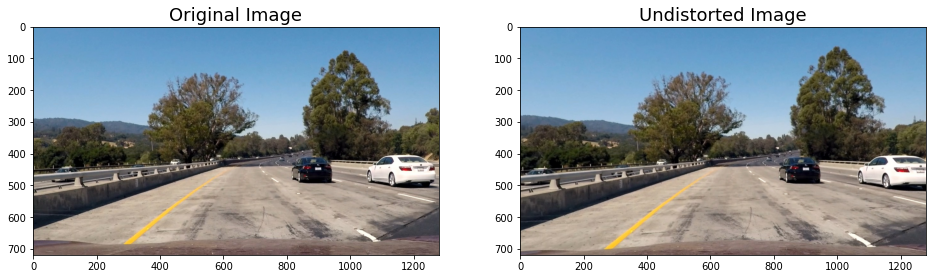

In [10]:
test_images = [mpimg.imread(path) for path in glob.glob("test_images/*")]

#undistord images
undistort_images = list(map(lambda img: undistort_image(img), test_images[:1]))

### Perspective transformation

A perspective transform maps the points in a given image to different, desired, image points with a new perspective. The perspective transform you’ll be most interested in is a bird’s-eye view transform that let’s us view a lane from above; this will be useful for calculating the lane curvature later on. Aside from creating a bird’s eye view representation of an image, a perspective transform can also be used for all kinds of different view points.

In [11]:
height, width = test_images[0].shape[:2]

# These source and destination points can be captured by reading an image using OpenCV cv2.imshow() function and by 
# pointing mouse pointer for target coordinates. An utility test file can be found from utils folder 

# source points
p1 = (575, 465)
p2 = (705, 465)
p3 = (255, 685)
p4 = (1050, 685)
line_color = (0, 255, 0) # Green

# destination points
pd1 = (450, 0)
pd2 = (width - 450, 0)
pd3 = (450, height)
pd4 = (width - 450, height)

In [12]:
def draw_polygon_on_image(img, line_color=(0, 255,0)):
    """
    This is used to draw a polygon on input image 
    
    :param img: Distortion corrected image
    :param line-color -
    :return: Same image with a drawn polygon by using selected image coordinatations
    """
    cv2.line(img, p1, p2, line_color, 3)
    cv2.line(img, p2, p4, line_color, 3)
    cv2.line(img, p4, p3, line_color, 3)
    cv2.line(img, p3, p1, line_color, 3)

    return  img

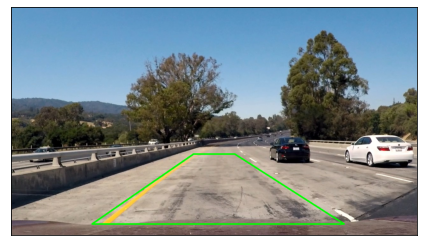

In [13]:
# Draw polygons on test images
src_selected_images = list(map(lambda img: draw_polygon_on_image(img), test_images))
show_images(src_selected_images[:1])

In [14]:
# define source and destination points for tranform
src = np.float32([p1, p2, p3, p4])
dst = np.float32([pd1, pd2, pd3, pd4])

def unwarp(img, source=src, desctination=dst):
    """
    This is used to select a region from a given undistortion image as bird eye perspective.
    
    :param img - Distortion corrected image
    :param src - source 
    :param dst - destination
    :return - warped image, transform matrix, and inverse
    """
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(source, desctination)
    Minv = cv2.getPerspectiveTransform(desctination, source)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

In [15]:
# Visualize undistortion images and unwaperd images
def visualize_warped_images(img):
    """
    This is an utility function to visualize both undistortion image and unwarped image
    
    :param img - An undistortion image
    :return - Unwarped image that can be reused
    """
    # Apply unwarp for raw image
    unwarped, _, _ = unwarp(img)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,16))
    img = draw_polygon_on_image(img)
    ax1.imshow(img)
    ax1.set_title('Undistorted Image', fontsize=18)
    ax2.imshow(unwarped)
    ax2.set_title('Unwarped Image', fontsize=18)
    
    # unwarped image
    return unwarped

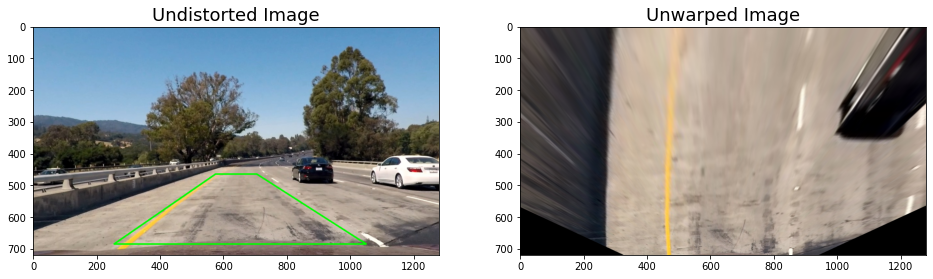

In [16]:
# Apply unwarp to get perspectives from test images
warped_images = list(map(lambda img: visualize_warped_images(img), undistort_images))

#### Test warped images with differnt colour spaces
Four different colour spaces were used to test warped images. 

In [18]:
# These utilitis are used to extract different color channels from different color spaces.

# Extract R,G, and B color channels from RGB color space.
def extract_rgb_color_spaces(uwimg):
    unwarp_R = uwimg[:, :, 0]
    unwarp_G = uwimg[:, :, 1]
    unwarp_B = uwimg[:, :, 2]
    
    return unwarp_R,unwarp_G,unwarp_B

# Extract H,S, and V color channels from HSV color space.
def extract_hsv_color_spaces(uwimg):
    unwarp_HSV = cv2.cvtColor(uwimg, cv2.COLOR_RGB2HSV)
    unwarp_H = unwarp_HSV[:, :, 0]
    unwarp_S = unwarp_HSV[:, :, 1]
    unwarp_V = unwarp_HSV[:, :, 2]
    
    return unwarp_H,unwarp_S,unwarp_V

# Extract H,S, and L color channels from HSL color space.
def extract_hsl_color_spaces(uwimg):
    unwarp_HSL = cv2.cvtColor(uwimg, cv2.COLOR_RGB2HLS)
    unwarp_HSL_H = unwarp_HSL[:, :, 0]
    unwarp_HSL_S = unwarp_HSL[:, :, 1]
    unwarp_HSL_L = unwarp_HSL[:, :, 2]
    
    return unwarp_HSL_H,unwarp_HSL_S,unwarp_HSL_L

# Extract L,A, and B color channels from LAB color space.
def extract_lab_color_spaces(uwimg):
    unwarped_LAB = cv2.cvtColor(uwimg, cv2.COLOR_RGB2Lab)
    unwarp_L = unwarped_LAB[:,:,0]
    unwarp_A = unwarped_LAB[:,:,1]
    unwarp_B = unwarped_LAB[:,:,2]
    
    return unwarp_L, unwarp_A,unwarp_B

In [20]:
def apply_rgb_filter(unwarp_img):
    #RGB
    unwarp_R,unwarp_G ,unwarp_B = extract_rgb_color_spaces(unwarp_img)
    fig, axs = plt.subplots(1, 3, figsize=(16, 16))
    axs = axs.ravel()
    axs[0].imshow(unwarp_R, cmap='gray')
    axs[0].set_title('RGB R-channel', fontsize=12)
    axs[1].imshow(unwarp_G, cmap='gray')
    axs[1].set_title('RGB G-Channel', fontsize=12)
    axs[2].imshow(unwarp_B, cmap='gray')
    axs[2].set_title('RGB B-channel', fontsize=12)


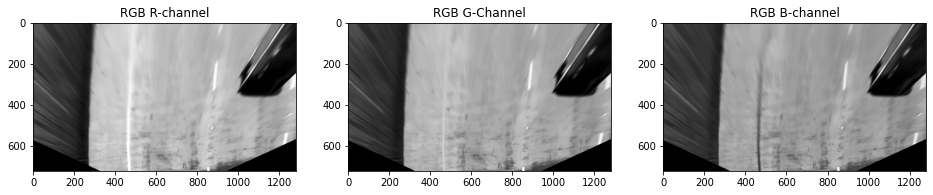

In [21]:
sample_img_test = warped_images[0]
apply_rgb_filter(sample_img_test)

In [23]:
def apply_hsv_filter(unwarp_img):
    # HSV
    unwarp_H,unwarp_S,unwarp_V = extract_hsv_color_spaces(unwarp_img)
    fig, axs = plt.subplots(1, 3, figsize=(16, 16))
    axs = axs.ravel()
    
    axs[0].imshow(unwarp_H, cmap='gray')
    axs[0].set_title('HSV H-Channel', fontsize=12)
    axs[1].imshow(unwarp_S, cmap='gray')
    axs[1].set_title('HSV S-channel', fontsize=12)
    axs[2].imshow(unwarp_V, cmap='gray')
    axs[2].set_title('HSV V-Channel', fontsize=12)


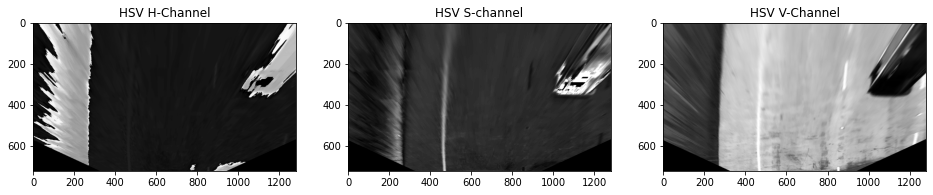

In [24]:
sample_img_test = warped_images[0]
apply_hsv_filter(sample_img_test)

In [25]:
def apply_hsl_filter(unwarp_img):
     # HSL
    unwarp_HSL_H,unwarp_HSL_S,unwarp_HSL_L = extract_hsl_color_spaces(unwarp_img)
    
    fig, axs = plt.subplots(1, 3, figsize=(16, 16))
    axs = axs.ravel()
    axs[0].imshow(unwarp_HSL_H, cmap='gray')
    axs[0].set_title('HSL H-Channel', fontsize=12)
    axs[1].imshow(unwarp_HSL_S, cmap='gray')
    axs[1].set_title('HSL S-channel', fontsize=12)
    axs[2].imshow(unwarp_HSL_L, cmap='gray')
    axs[2].set_title('HSL V-Channel', fontsize=12)


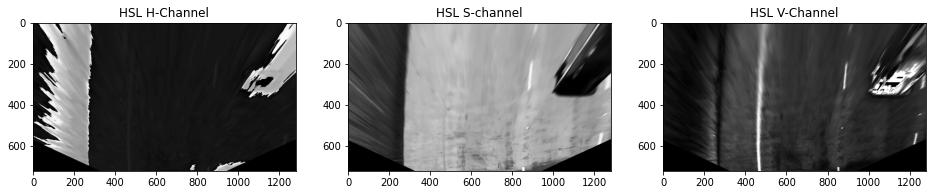

In [26]:
sample_img_test = warped_images[0]
apply_hsl_filter(sample_img_test)

In [27]:
def apply_lab_filter(unwarp_img):
    # LAB
    unwarp_L, unwarp_A,unwarp_B = extract_lab_color_spaces(unwarp_img)
    
    fig, axs = plt.subplots(1, 3, figsize=(16, 16))
    axs = axs.ravel()
    axs[0].imshow(unwarp_L, cmap='gray')
    axs[0].set_title('LAB L-Channel', fontsize=12)
    axs[1].imshow(unwarp_A, cmap='gray')
    axs[1].set_title('LAB A-channel', fontsize=12)
    axs[2].imshow(unwarp_B, cmap='gray')
    axs[2].set_title('LAB B-Channel', fontsize=12)

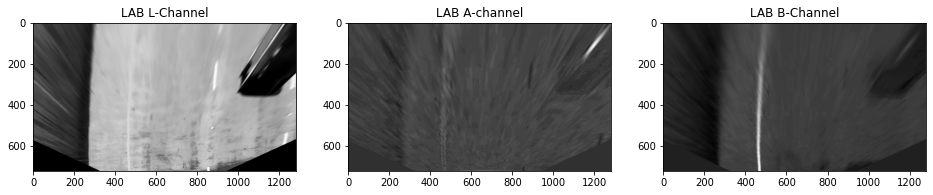

In [28]:
sample_img_test = warped_images[0]
apply_lab_filter(sample_img_test)

####  Sobel Thresolding


In [ ]:
def abs_sobel_thresh(gray, orient='x', thresh_min=0, thresh_max=255):
    # Apply the following steps to img
    # 1) Convert to grayscale
#     gray = grayscale(img)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    dx = 1 if orient=='x'  else  0
    dy = 1 if orient=='y'  else  0

    sobel = cv2.Sobel(gray, cv2.CV_64F,dx ,dy)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude
            # is > thresh_min and < thresh_max
    binary_sobel = np.zeros_like(scaled_sobel)
    binary_sobel[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary_sobel

In [ ]:
def apply_sobel_threshold(img, gray, min_thresh, max_thresh):
    """
    :param unwarp_img:
    :param min_thresh:
    :param max_thresh:
    :return:
    """
    abs_sobel = abs_sobel_thresh(gray, 'x', min_thresh, max_thresh)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 16))
    ax1.imshow(img)
    ax1.set_title('Unwarped Image', fontsize=18)
    
    ax2.imshow(abs_sobel, cmap='gray')
    ax2.set_title('Sobel Absolute', fontsize=18)
    plt.show()

### Test with different colour spaces

#### RGB Grayscale 

In [ ]:
min_thresh=50
max_thresh=190

sample_img = warped_images[1]
gray = grayscale(sample_img)
apply_sobel_threshold(sample_img,gray,min_thresh, max_thresh)


#### RGB R color space

In [ ]:
sample_img = warped_images[1]
gray_rgb,_,_ = extract_rgb_color_spaces(sample_img)
apply_sobel_threshold(sample_img,gray_rgb,min_thresh, max_thresh)


#### HSV V color space

In [ ]:
sample_img = warped_images[1]
_,_,gray_hsv = extract_hsv_color_spaces(sample_img)
apply_sobel_threshold(sample_img,gray_hsv,min_thresh, max_thresh)


#### HSL S color space

In [ ]:
sample_img = warped_images[1]
_,gray_hsl,_ = extract_hsl_color_spaces(sample_img)
apply_sobel_threshold(sample_img,gray_hsl,min_thresh, max_thresh)


#### LAB L color space

In [ ]:
sample_img = warped_images[1]
gray_lab,_,_ = extract_lab_color_spaces(sample_img)
apply_sobel_threshold(sample_img,gray_lab,min_thresh, max_thresh)

#### Magnitude of the gradient

In [ ]:
def mag_threshold(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
#     gray = grayscale(img) # extract HSL L color scpace
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


In [ ]:
def apply_sobel_mag_gradient(uwimg,gray,sobel_kernel, min_thresh, max_thresh):
    
    sobel_mag = mag_threshold(gray, sobel_kernel,(min_thresh, max_thresh))
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,16))
    ax1.imshow(uwimg)
    ax1.set_title('Unwarped Image', fontsize=18)
    ax2.imshow(sobel_mag, cmap='gray')
    ax2.set_title('Sobel Magnitude', fontsize=18)

#### RGB Grayscale 

In [ ]:
min_thresh=50
max_thresh=190
sobel_kernel = 15

sample_img = warped_images[1]
gray = grayscale(sample_img)
apply_sobel_mag_gradient(sample_img, gray, sobel_kernel, min_thresh, max_thresh)


#### RGB R color space

In [ ]:
sample_img = warped_images[1]
gray_rgb,_,_ = extract_rgb_color_spaces(sample_img)
apply_sobel_mag_gradient(sample_img, gray_rgb, sobel_kernel, min_thresh, max_thresh)


#### HSV V color space

In [ ]:
sample_img = warped_images[1]
_,_,gray_hsv = extract_hsv_color_spaces(sample_img)
apply_sobel_mag_gradient(sample_img, gray_hsv, sobel_kernel, min_thresh, max_thresh)


#### HSL S color space

In [ ]:
sample_img = warped_images[1]
_,gray_hsl,_ = extract_hsl_color_spaces(sample_img)
apply_sobel_mag_gradient(sample_img, gray_hsl, sobel_kernel, min_thresh, max_thresh)


#### LAB L color space

In [ ]:
sample_img = warped_images[1]
gray_lab,_,_ = extract_lab_color_spaces(sample_img)
apply_sobel_mag_gradient(sample_img, gray_lab, sobel_kernel, min_thresh, max_thresh)

#### Direction of the gradient

In [ ]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
#     gray = grayscale(img) # extract HSL L color scpace
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    binary_output =  np.ones_like(absgraddir)
    
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 0

    # Return the binary image
    return binary_output

In [ ]:
def apply_sobel_dir_gradient(uwimg,gray,sobel_kernel, min_thresh, max_thresh):
    
    sobel_mag = dir_threshold(gray, sobel_kernel,(min_thresh, max_thresh))
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,16))
    ax1.imshow(uwimg)
    ax1.set_title('Unwarped Image', fontsize=18)
    
    ax2.imshow(sobel_mag, cmap='gray')
    ax2.set_title('Sobel Direction', fontsize=18)

In [ ]:
dir_min_thresh=0.3
dir_max_thresh=1.51
dir_sobel_kernel = 15

sample_img = warped_images[1]
gray = grayscale(sample_img)
apply_sobel_dir_gradient(sample_img, gray, dir_sobel_kernel, dir_min_thresh, dir_max_thresh)


In [ ]:
sample_img = warped_images[1]
gray_rgb,_,_ = extract_rgb_color_spaces(sample_img)
apply_sobel_dir_gradient(sample_img, gray_rgb, dir_sobel_kernel, dir_min_thresh, dir_max_thresh)


In [ ]:
sample_img = warped_images[1]
_,_,gray_hsv = extract_hsv_color_spaces(sample_img)
apply_sobel_dir_gradient(sample_img, gray_hsv, dir_sobel_kernel, dir_min_thresh, dir_max_thresh)


In [ ]:
sample_img = warped_images[1]
_,gray_hsl,_ = extract_hsl_color_spaces(sample_img)
apply_sobel_dir_gradient(sample_img, gray_hsl, dir_sobel_kernel, dir_min_thresh, dir_max_thresh)


In [ ]:
sample_img = warped_images[1]
gray_lab,_,_ = extract_lab_color_spaces(sample_img)
apply_sobel_dir_gradient(sample_img, gray_lab, dir_sobel_kernel, dir_min_thresh, dir_max_thresh)


#### Sobel Magnitude and Direction

In [ ]:
def combine_thresholds(unwarp_img, gray, mag_kernel, mag_thresh, dir_thresh, dir_kernel ):
   
    gradx = abs_sobel_thresh(gray, orient='x', thresh_min=mag_thresh[0], thresh_max=mag_thresh[1])
    grady = abs_sobel_thresh(gray, orient='y', thresh_min=mag_thresh[0], thresh_max=mag_thresh[1])
    
    mag_binary = mag_threshold(gray, sobel_kernel=mag_kernel, mag_thresh=mag_thresh)
    
    dir_binary = dir_threshold(gray, sobel_kernel=dir_kernel, thresh=dir_thresh)
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined


In [ ]:
def visualize_combine_imgages(unwarp_img, gray, mag_kernel, mag_thresh, dir_thresh, dir_kernel):
    combined = combine_thresholds(unwarp_img, gray, mag_kernel, mag_thresh, dir_thresh, dir_kernel )
    # Visualize sobel magnitude + direction threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,16))
    
    ax1.imshow(unwarp_img)
    ax1.set_title('Unwarped Image', fontsize=18)
    
    ax2.imshow(combined, cmap='gray')
    ax2.set_title('Sobel Magnitude + Direction', fontsize=18)
    

#### RGB to grayscale

In [ ]:
dir_thresh= (0.3 ,1.51)
dir_sobel_kernel = 15

mag_thresh = (50, 190)
mg_sobel_kernel = 15

# sample_img = warped_images[1]
for sample_img in warped_images[:2]:
    gray = grayscale(sample_img)
    visualize_combine_imgages(sample_img, gray, mg_sobel_kernel,mag_thresh, dir_thresh, dir_sobel_kernel)

#### RGB R color space 

In [ ]:
# sample_img = warped_images[1]
for sample_img in warped_images[:2]:
    gray_rgb,_,_ = extract_rgb_color_spaces(sample_img)
    visualize_combine_imgages(sample_img, gray_rgb, mg_sobel_kernel,mag_thresh, dir_thresh, dir_sobel_kernel)

#### HSV V color space

In [ ]:
# sample_img = warped_images[1]
for sample_img in warped_images[:2]:
    _,_,gray_hsv = extract_hsv_color_spaces(sample_img)
    visualize_combine_imgages(sample_img, gray_hsv, mg_sobel_kernel,mag_thresh, dir_thresh, dir_sobel_kernel)

#### HSL S color space

In [ ]:
for warped_img in warped_images[:2]:
    _,gray_hsl,_ = extract_hsl_color_spaces(warped_img)
    visualize_combine_imgages(warped_img, gray_hsl, mg_sobel_kernel,mag_thresh, dir_thresh, dir_sobel_kernel)

#### LAB L color space

In [ ]:
for sample_img in warped_images[:2]:
    gray_lab,_,_ = extract_lab_color_spaces(sample_img)
    visualize_combine_imgages(sample_img, gray_lab, mg_sobel_kernel,mag_thresh, dir_thresh, dir_sobel_kernel)

In [ ]:
# Use exclusive lower bound (>) and inclusive upper (<=)
def hsl_threshold(img, thresh=(220, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
    hls_l = hls_l*(255/np.max(hls_l))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(hls_l)
    binary_output[(hls_l > thresh[0]) & (hls_l <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output


In [ ]:
sample_img = warped_images[1]
hsl_s = hsl_threshold(sample_img)
plt.imshow(hsl_s, cmap='gray')
plt.show()

In [ ]:
def lab_threshold(unwarped_img, thresh=(190,255)):
    lab = cv2.cvtColor(unwarped_img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output


In [ ]:
sample_img = warped_images[0]
lab = lab_threshold(sample_img)
plt.imshow(lab, cmap='gray')
plt.show()

### Pipeline

In [ ]:
def pipeline(p_img):
    
    # Undistort images
    undistort_img = undistort(p_img)
    
    # Persfective transform
    img_unwarp,M, Minv = unwarp(undistort_img, src, dst)
    
    # HLS L-channel Threshold (using default parameters)
    img_hsl_L = hsl_threshold(img_unwarp)

    # Lab B-channel Threshold (using default parameters)
    img_lab_B = lab_threshold(img_unwarp)
    
    # Combine HLS and Lab B channel thresholds
    combined = np.zeros_like(img_lab_B)
    combined[(img_hsl_L == 1) | (img_lab_B == 1)] = 1
    
    return combined, Minv
    

#### Test pipeline for test images

In [ ]:
# Make a list of example images
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(16, 16))
# fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_bin,MinV = pipeline(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1
    

#### Histogram Peaks

In [ ]:
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

In [ ]:
# img = cv2.imread(images[0])
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img_bin,Minv = pipeline(img)
# histogram = hist(img_bin)
# # print(histogram)
# plt.plot(histogram)
# plt.show()

#### Sliding Window

In [ ]:
# Define method to fit polynomial to binary image with lines extracted, using sliding window
def sliding_window_polyfit(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram (directly to the left/right) is considered
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    
    #print('base pts:', leftx_base, rightx_base)

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data

In [ ]:
def extract_visualize_data(original_img):
    original_img_bin, Minv = pipeline(original_img)
    
    left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(original_img_bin)

    h = original_img.shape[0]
    left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
    right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
    #print('fit x-intercepts:', left_fit_x_int, right_fit_x_int)

    rectangles = visualization_data[0]
    histogram = visualization_data[1]

    # Create an output image to draw on and  visualize the result
    out_img = np.uint8(np.dstack((original_img_bin, original_img_bin, original_img_bin))*255)
    # Generate x and y values for plotting
    ploty = np.linspace(0, original_img_bin.shape[0]-1, original_img_bin.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    for rect in rectangles:
    # Draw the windows on the visualization image
        cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
        cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = original_img_bin.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

In [ ]:
# visualize the result on example image
images = glob.glob('./test_images/*.jpg')
img = cv2.imread(images[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
extract_visualize_data(img)
    

In [ ]:
# TODO plot a histogram

#### Polyfit using previous frame windows

In [ ]:
# Define method to fit polynomial to binary image based upon a previous fit (chronologically speaking);
# this assumes that the fit will not change significantly from one video frame to the next
def polyfit_using_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
        
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds


In [ ]:

def draw_polygon_and_fill(original_img):
    original_img_bin, Minv = pipeline(original_img)
    left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(original_img_bin)
    
    left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = polyfit_using_prev_fit(original_img_bin, left_fit, right_fit)

    # Generate x and y values for plotting
    ploty = np.linspace(0, original_img_bin.shape[0]-1, original_img_bin.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
    right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.uint8(np.dstack((original_img_bin, original_img_bin, original_img_bin))*255)
    window_img = np.zeros_like(out_img)

    # Color in left and right line pixels
    nonzero = original_img_bin.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]
    
    margin = 80
    # Generate a polygon to illustrate the search window area (OLD FIT)
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx2, ploty, color='yellow')
    plt.plot(right_fitx2, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)


In [ ]:
# visualize the result on example image
images = glob.glob('./test_images/*.jpg')
img = cv2.imread(images[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
draw_polygon_and_fill(img)

In [ ]:
#### TODO Radius of curvature and distance from center calculation

In [ ]:
# Method to determine radius of curvature and distance from lane center 
# based on binary image, polynomial fit, and L and R lane pixel indices
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist


In [ ]:
exampleImg = cv2.imread('./test_images/test2.jpg')
exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)
exampleImg_bin, Minv = pipeline(exampleImg)
left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(exampleImg_bin)
rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(exampleImg_bin, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center for example:', d_center, 'm')

In [ ]:
def draw_lane(original_img):
    original_img_bin, Minv = pipeline(original_img) 
    l_fit,r_fit,_,_,_ = sliding_window_polyfit(original_img_bin)
    
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(original_img_bin).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = original_img_bin.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

In [ ]:
res = draw_lane(exampleImg)
plt.imshow(res)
plt.show()

#### Draw curvature radius and distance from center data onto a original image

In [ ]:
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

In [ ]:
output = draw_data(res, (rad_l+rad_r)/2, d_center)
plt.imshow(output)

In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)


In [ ]:
def process_image(img):
    new_img = np.copy(img)
    img_bin, Minv = pipeline(new_img)
    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window_polyfit(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_using_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
        
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            l_fit = None
            r_fit = None
            
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(new_img)
        rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
        img_out = draw_data(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img
    
    diagnostic_output = False
    if diagnostic_output:
        # put together multi-view output
        diag_img = np.zeros((720,1280,3), dtype=np.uint8)
        
        # original output (top left)
        diag_img[0:360,0:640,:] = cv2.resize(img_out,(640,360))
        
        # binary overhead view (top right)
        img_bin = np.dstack((img_bin*255, img_bin*255, img_bin*255))
        resized_img_bin = cv2.resize(img_bin,(640,360))
        diag_img[0:360,640:1280, :] = resized_img_bin
        
        # overhead with all fits added (bottom right)
        img_bin_fit = np.copy(img_bin)
        for i, fit in enumerate(l_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (20*i+100,0,20*i+100))
        for i, fit in enumerate(r_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (0,20*i+100,20*i+100))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, l_line.best_fit, (255,255,0))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, r_line.best_fit, (255,255,0))
        diag_img[360:720,640:1280,:] = cv2.resize(img_bin_fit,(640,360))
        
        # diagnostic data (bottom left)
        color_ok = (200,255,155)
        color_bad = (255,155,155)
        font = cv2.FONT_HERSHEY_DUPLEX
        if l_fit is not None:
            text = 'This fit L: ' + ' {:0.6f}'.format(l_fit[0]) + \
                                    ' {:0.6f}'.format(l_fit[1]) + \
                                    ' {:0.6f}'.format(l_fit[2])
        else:
            text = 'This fit L: None'
        cv2.putText(diag_img, text, (40,380), font, .5, color_ok, 1, cv2.LINE_AA)
        if r_fit is not None:
            text = 'This fit R: ' + ' {:0.6f}'.format(r_fit[0]) + \
                                    ' {:0.6f}'.format(r_fit[1]) + \
                                    ' {:0.6f}'.format(r_fit[2])
        else:
            text = 'This fit R: None'
        cv2.putText(diag_img, text, (40,400), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit L: ' + ' {:0.6f}'.format(l_line.best_fit[0]) + \
                                ' {:0.6f}'.format(l_line.best_fit[1]) + \
                                ' {:0.6f}'.format(l_line.best_fit[2])
        cv2.putText(diag_img, text, (40,440), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit R: ' + ' {:0.6f}'.format(r_line.best_fit[0]) + \
                                ' {:0.6f}'.format(r_line.best_fit[1]) + \
                                ' {:0.6f}'.format(r_line.best_fit[2])
        cv2.putText(diag_img, text, (40,460), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Diffs L: ' + ' {:0.6f}'.format(l_line.diffs[0]) + \
                             ' {:0.6f}'.format(l_line.diffs[1]) + \
                             ' {:0.6f}'.format(l_line.diffs[2])
        if l_line.diffs[0] > 0.001 or \
           l_line.diffs[1] > 1.0 or \
           l_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,500), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Diffs R: ' + ' {:0.6f}'.format(r_line.diffs[0]) + \
                             ' {:0.6f}'.format(r_line.diffs[1]) + \
                             ' {:0.6f}'.format(r_line.diffs[2])
        if r_line.diffs[0] > 0.001 or \
           r_line.diffs[1] > 1.0 or \
           r_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,520), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Good fit count L:' + str(len(l_line.current_fit))
        cv2.putText(diag_img, text, (40,560), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Good fit count R:' + str(len(r_line.current_fit))
        cv2.putText(diag_img, text, (40,580), font, .5, color_ok, 1, cv2.LINE_AA)
        
        img_out = diag_img
    return img_out

In [ ]:
def plot_fit_onto_img(img, fit, plot_color):
    if fit is None:
        return img
    new_img = np.copy(img)
    h = new_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    plotx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    pts = np.array([np.transpose(np.vstack([plotx, ploty]))])
    cv2.polylines(new_img, np.int32([pts]), isClosed=False, color=plot_color, thickness=8)
    return new_img

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
l_line = Line()
r_line = Line()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'output_videos/project_video_output.mp4'
video_input1 = VideoFileClip('input_videos/project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(processed_video))

In [ ]:
l_line = Line()
r_line = Line()
video_output2 = 'output_videos/challenge_video_output.mp4'
video_input2 = VideoFileClip('input_videos/challenge_video.mp4')#.subclip(10,12)
#video_input2.save_frame("challenge01.jpeg", t=0.25) # saves the frame at time = 0.25s
processed_video = video_input2.fl_image(process_image)
%time final_output = processed_video.write_videofile(video_output2, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(final_output))

In [ ]:
l_line = Line()
r_line = Line()
video_output3 = 'output_videos/harder_challenge_video_output.mp4'
video_input3 = VideoFileClip('input_videos/harder_challenge_video.mp4')#.subclip(0,3)
#video_input3.save_frame("hard_challenge01.jpeg") # saves the first frame
processed_video = video_input3.fl_image(process_image)
%time processed_video.write_videofile(video_output3, audio=False)

In [ ]:
# # Download IPython notebook as HTML file
import os
os.system('jupyter nbconvert --to html Advanced_Lane_Finding.ipynb')